# **Projet 6 - Parcours Data Scientist - Openclassroom**
### *Adrien Aprile*
## **Partie I : Analyse exploratoire**

### *Import des données* 

In [1]:
#import des données
import numpy as np
import pandas as pd
import os
import glob
os.chdir(r"C:\Users\adrien\NOTEBOOK Python\Projet_6\data")
path = "D:\OpenClassRoom\Projet 6\data"
allFiles = glob.glob(os.path.join(path, "*.csv"))
df = pd.read_csv(allFiles[0],sep=',')
for f in allFiles[1:]:
    df_temp = pd.read_csv(f,sep=',')
    df = df.append(df_temp,ignore_index = True)
print(df.shape)

(196905, 43)


In [2]:
#Suppression des lignes sans tags 
df.dropna(subset=['Tags'],inplace=True)
df.reset_index(inplace=True,drop = True)
df.shape

(47303, 43)

In [3]:
#Sélection des colonnes qui nous intéressent et apperçu :
df = df[["Body","Title","Tags"]]
df.head()

,Body,Title,Tags
0,<p>I want to use a track-bar to change a form'...,"While applying opacity to a form, should we us...",<c#><winforms><type-conversion><decimal><opacity>
1,<p>I have an absolutely positioned <code>div</...,Percentage width child element in absolutely p...,<html><css><css3><internet-explorer-7>
2,<p>Given a <code>DateTime</code> representing ...,How do I calculate someone's age in C#?,<c#><.net><datetime>
3,<p>Given a specific <code>DateTime</code> valu...,Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...
4,<p>Is there any standard way for a Web Server ...,Determine a User's Timezone,<javascript><html><browser><timezone><timezone...


### *Cleaning des variables Body,Title et tags :*

In [4]:
#Fonction lower_case + supprime ponctuation (sauf +,#,-),chiffre + lemmatizer (nom + verbe)
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
def text_to_words(text):
    if pd.isna(text):
        return " "
    else :
        textBS = BeautifulSoup(text,"lxml")
        letters_only = re.sub("[^a-zA-Z+#\-]",           
                          " ",                  
                          textBS.get_text() )
        lower_case = letters_only.lower()
        words = lower_case.split()
        wordnet_lemmatizer = WordNetLemmatizer()
        words_lemmatised = [wordnet_lemmatizer.lemmatize(w,pos="n") for w in words]
        words_lemmatised = [wordnet_lemmatizer.lemmatize(w,pos="v") for w in words_lemmatised]
        return(" ".join( words_lemmatised ))

In [5]:
clean_Body = []
clean_Title = []

print("... Processing Body cleaning:")
for i in tqdm(range(0,len(df["Body"]))):
    clean_Body.append(text_to_words(df["Body"][i]))
 
print("... Processing Title cleaning:")
for i in tqdm(range(0,len(df["Body"]))):
    clean_Title.append(text_to_words(df["Title"][i]))

... Processing Body cleaning:


100%|███████████████████████████████████████████████████████████████████████████| 47303/47303 [01:00<00:00, 785.59it/s]


... Processing Title cleaning:


100%|██████████████████████████████████████████████████████████████████████████| 47303/47303 [00:17<00:00, 2651.23it/s]


In [6]:
# Avant - Après cleaning :
print(df["Body"][0])
print(clean_Body[0])

<p>I want to use a track-bar to change a form's opacity.</p>

<p>This is my code:</p>

<pre><code>decimal trans = trackBar1.Value / 5000;
this.Opacity = trans;
</code></pre>

<p>When I build the application, it gives the following error:</p>

<blockquote>
  <p>Cannot implicitly convert type <code>'decimal'</code> to <code>'double'</code>.</p>
</blockquote>

<p>I tried using <code>trans</code> and <code>double</code> but then the control doesn't work. This code worked fine in a past VB.NET project.</p>

i want to use a track-bar to change a form s opacity this be my code decimal trans trackbar value this opacity trans when i build the application it give the follow error cannot implicitly convert type decimal to double i try use trans and double but then the control doesn t work this code work fine in a past vb net project


In [7]:
#Cleaning des tags :
clean_Tags = []
for i in range(0,len(df["Tags"])):
    words = df["Tags"][i]
    words = re.sub("[<>]",           
                          " ",                  
                          words )
    clean_Tags.append(words)

In [8]:
# Avant - Après cleaning des tags :
print(df["Tags"][0])
print(clean_Tags[0])

<c#><winforms><type-conversion><decimal><opacity>
 c#  winforms  type-conversion  decimal  opacity 


In [9]:
# Création variable regroupant Body et Title pour chaque questions : 
clean_text = []
for i in range(0,len(clean_Body)):
    clean_text.append(clean_Body[i]+ " " +clean_Title[i])
    
#Apperçu : 
print(clean_text[0])

i want to use a track-bar to change a form s opacity this be my code decimal trans trackbar value this opacity trans when i build the application it give the follow error cannot implicitly convert type decimal to double i try use trans and double but then the control doesn t work this code work fine in a past vb net project while apply opacity to a form should we use a decimal or a double value


In [10]:
#Tfidf sur notre texte (avec filtre des stopwords) : 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=10000,stop_words='english',min_df=40,max_df=0.25,ngram_range=(1,3))
X = tfidf.fit_transform(clean_text)
X_vocabulary = tfidf.get_feature_names()
#Sparse matrice avec 7543 variables pour 47303 lignes
X.shape

(47303, 7543)

In [11]:
#Countvectorizer pour partie non supervisée : 
from sklearn.feature_extraction.text import CountVectorizer


count_vectorizer = CountVectorizer(max_features=100000,stop_words='english',min_df=200,max_df=0.05,ngram_range=(1,2))
X_lda = count_vectorizer.fit_transform(clean_text)
X_vocab_lda = count_vectorizer.get_feature_names()
X_lda.shape

(47303, 1413)

In [12]:
# Fonction qui transforme la liste des tags en sparse matrix:
import collections
from itertools import chain
from scipy.sparse import csr_matrix
def tag_to_sparse(docs):
    docs_list = list(chain(*docs))
    docs_list = [w for doc in docs for w in doc]
    counter = collections.Counter(docs_list)
    count_pairs = sorted(counter.items(), key=lambda x: -x[1])
    vocabulary = dict([(c[0], i) for i, c in enumerate(count_pairs)])

    row_ind = list()
    col_ind = list()
    for i, doc in enumerate(docs):
        for w in doc:
            row_ind.append(i)
            col_ind.append(vocabulary[w])
    value = [1]*len(row_ind)
    X = csr_matrix((value, (row_ind, col_ind)))
    X.sum_duplicates()
    return X, vocabulary, count_pairs

In [13]:
# Creation sparse matrix pour les tags: 
docs = list(map(lambda s: s.lower().split(), clean_Tags))
y, dict_tags,count_tags = tag_to_sparse(docs)
# On récupère la liste de tous les tags uniques classé par leur nombre d'apparitions dans notre data set : 
liste_tags = []
for key, value in dict_tags.items():
    liste_tags.append(key)
print("20 premiers tags : ", liste_tags[:20])
print("Nombre de tags:",len(liste_tags))

20 premiers tags :  ['c#', '.net', 'java', 'asp.net', 'c++', 'javascript', 'python', 'php', 'sql', 'sql-server', 'windows', 'html', 'visual-studio', 'database', 'c', 'mysql', 'ruby', 'xml', 'winforms', 'css']
Nombre de tags: 9179


### *Analyse et visualisation :*

In [14]:
#Fonction permettant de sortir un liste des n mot les plus fréquents et leur compte dans le data set :
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    vectorized_headlines = count_vectorizer.fit_transform(text_data.as_matrix())
    
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

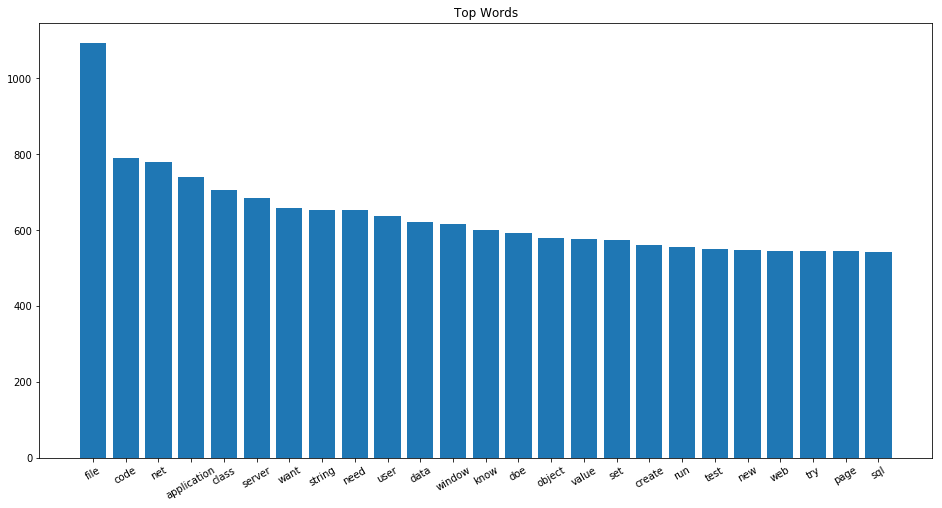

In [22]:
os.chdir(r"C:\Users\adrien\NOTEBOOK Python\Projet_6\Export")
#Visualisation des 25 premiers mots :
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
df_Body_Title = pd.DataFrame(clean_text)
text = df_Body_Title[0]
words, word_values = get_top_n_words(n_top_words=25, count_vectorizer=tfidf, text_data=text)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words,rotation =30)
ax.set_title('Top Words')
plt.savefig('topword.png',bbox_inches='tight')
plt.show()

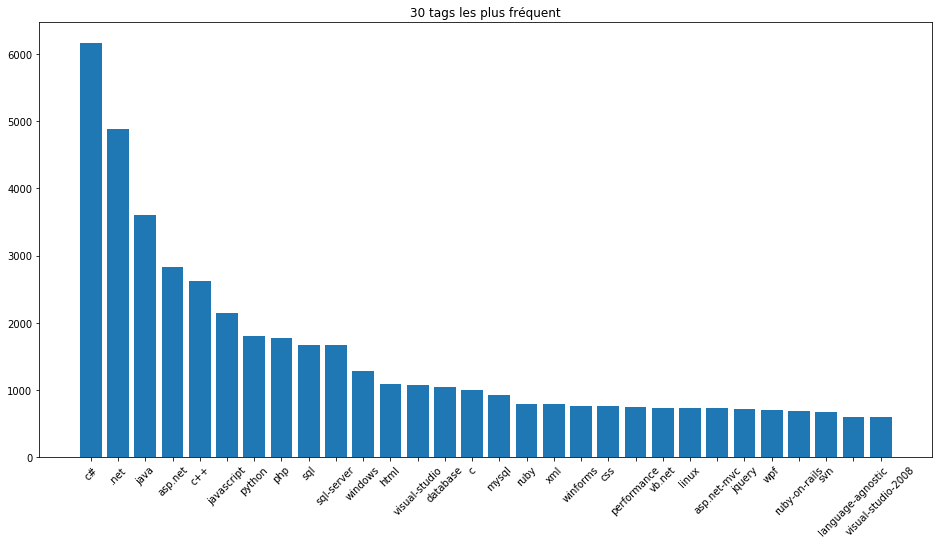

In [21]:
#Visualisation 30 tags les plus fréquents : 
count = []
tags_words = []
for i in range(0,30):
    count.append(count_tags[i][1])
    tags_words.append(count_tags[i][0])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(tags_words)), count,width = 0.8)
ax.set_xticks(range(len(tags_words)))
ax.set_xticklabels(tags_words,rotation=45)
ax.set_title('30 tags les plus fréquent')
plt.savefig('toptag.png',bbox_inches='tight')
plt.show()

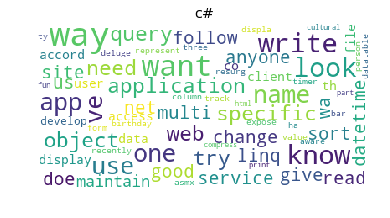

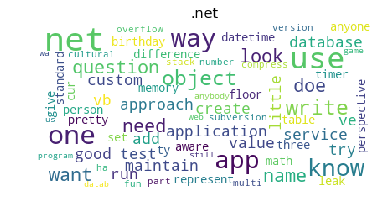

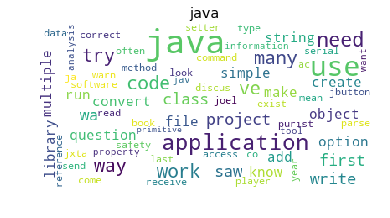

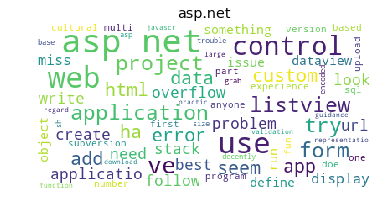

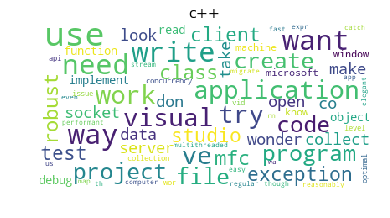

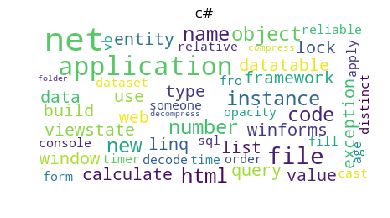

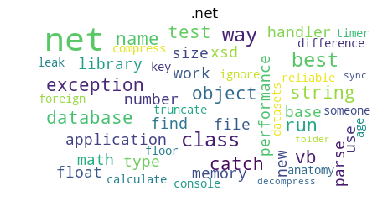

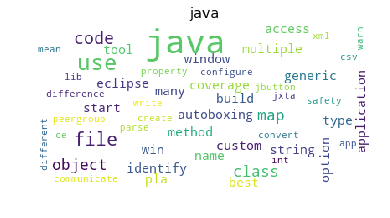

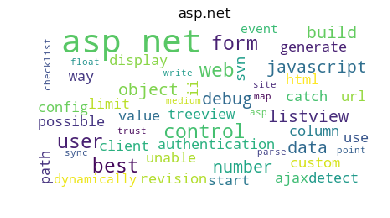

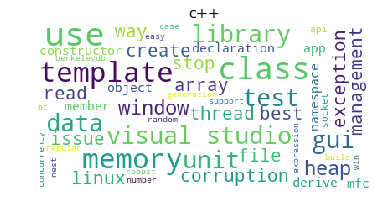

In [17]:
# Visualisation wordcloud pour quelques tags : 
import matplotlib as mpl
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

df_clean_body = pd.DataFrame(clean_Body)
df_clean_title = pd.DataFrame(clean_Title)
df_clean_text = pd.DataFrame(clean_text)


#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

#5 premiers tag wordcloud avec body : 
for i in range(0,5):
    file_name = "body_" + str(i) +".png"
    index_tag = y[:,i].nonzero()[0]
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
                              stopwords=stopwords,
                              background_color='white',
                              max_words=70,
                              max_font_size=40, 
                              random_state=42
                             ).generate(str(df_clean_body[0].iloc[index_tag]))


    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.title(liste_tags[i])
    plt.axis('off')
    plt.savefig(file_name)
    plt.show()
    

#5 premiers tag wordcloud avec title : 
for i in range(0,5):
    file_name2 = "title_" + str(i) +".png"
    index_tag = y[:,i].nonzero()[0]
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
                              stopwords=stopwords,
                              background_color='white',
                              max_words=50,
                              max_font_size=40, 
                              random_state=42
                             ).generate(str(df_clean_title[0].iloc[index_tag]))


    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.title(liste_tags[i])
    plt.axis('off')
    plt.savefig(file_name2)
    plt.show()

### *Export des datas :* 

In [18]:
from scipy import sparse
import csv
import pickle
#X,y
sparse.save_npz("X_matrix.npz",X)
sparse.save_npz("y_matrix.npz",y)
sparse.save_npz("X_matrix_lda.npz",X_lda)
#Vocabulaire: 

csvfile = "Vocabulary.csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator=',')
    for val in X_vocabulary:
        writer.writerow([val])  
  

csvfile_lda = "Vocabulary_lda.csv"
with open(csvfile_lda, "w") as output:
    writer = csv.writer(output, lineterminator=',')
    for val in X_vocab_lda:
        writer.writerow([val])  
        
#Tags :
csvfile = "tags.csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator=',')
    for val in liste_tags:
        writer.writerow([val])  
        
#tfidf: 
with open('tfidf.pk', 'wb') as fin:
    pickle.dump(tfidf, fin)